#### Imports

In [1]:
import numpy as np
import pandas as pd

In [2]:
from razdel import sentenize

In [3]:
import random

In [4]:
from tqdm import tqdm

In [5]:
import re
import os

#### User-defined

In [6]:
from processing import REMAIN_PUNCT, END_PUNC, PUNCT_TO_TOKEN
from processing import process_raw_sentence, tokenize

#### Visualisation

In [7]:
import matplotlib
import matplotlib.pyplot as plt

In [8]:
import scienceplots

plt.style.use('science')
%config InlineBackend.figure_format = 'retina'

lables_fs = 16
ticks_fs = 12

## All downloaded books by Pushkin

In [9]:
pushkin_raw_dir = '../data/raw/pushkin'

In [10]:
books = []

for file in os.listdir(pushkin_raw_dir):  # through files in selected directory            
    filename = os.fsdecode(file)
    if filename.endswith(".txt"):  # looking for .txt files in the directory
        books.append(filename)

print(*books, sep='\n')

dubrovsky.txt
povesti_belkina.txt
kapitanskaya_dochka.txt
pugachevs_story.txt


In [11]:
# select book!
book_filename = books[3]
book_filename

'pugachevs_story.txt'

In [12]:
with open(os.path.join(pushkin_raw_dir, book_filename), 'r') as file:
    book_raw = file.read()

### Splitting by chapters

In [13]:
# also chapters can be detected by their length!
chapter_length_th = 1000  # chapter length threshold

chapter_num = 1
for prt in re.split('\n\n', book_raw):
    if len(prt) > chapter_length_th:
        print(f'{len(prt)}\t<- Chapter {chapter_num}')
        chapter_num += 1
    else:
        print(len(prt))

44
12
1607	<- Chapter 1
12118	<- Chapter 2
25
2
7462	<- Chapter 3
1
74
1
1269	<- Chapter 4
1
252
1
5531	<- Chapter 5
1
1479	<- Chapter 6
1
11986	<- Chapter 7
1
6525	<- Chapter 8
1
139
2
22
12
20303	<- Chapter 9
25
2
250
1
2346	<- Chapter 10
1
436
1
52
1
205
1
171
1
776
1
92
1
256
2
1316	<- Chapter 11
2
297
2
61
2
105
2
90
2
222
12
26233	<- Chapter 12
26
2
18
1
216
1
117
1
99
1
20
1
139
1
276
1
48
1
565
2
486
2
215
2
65
2
288
2
84
2
186
2
59
2
220
2
43
2
358
2
57
2
618
15
19792	<- Chapter 13
28
2
210
1
265
1
234
1
1674	<- Chapter 14
1
6030	<- Chapter 15
1
118
1
1199	<- Chapter 16
1
59
1
51
2
82
2
54
2
94
2
38
2
6823	<- Chapter 17
2
204
2
639
11
28304	<- Chapter 18
24
2
171
1
195
1
137
1
315
1
44
1
1714	<- Chapter 19
1
206
1
190
1
111
2
896
2
238
2
182
2
291
2
669
2
345
2
255
2
7
2
422
2
401
2
193
2
1947	<- Chapter 20
12
15681	<- Chapter 21
25
2
33
1
42
1
106
1
164
1
205
13
13209	<- Chapter 22
26
2
190
1
2502	<- Chapter 23
489
1
248
1
320
12
31013	<- Chapter 24
25
2
195
1
238
1
194
1
242

In [14]:
chapters_list = []  # list with chapters text (with replaced '\n' by ' ')

for text_part in re.split('\n\n', book_raw):  # includes paragraphs with chapter's numbers and epigraphs
    if len(text_part) > chapter_length_th:
        text_part = text_part.replace('\n', ' ')
        text_part = re.sub('[\[].*?[\]]', '', text_part)
        chapters_list.append(text_part)  # add chapter text without '\n'

In [15]:
print(f'Number of chapters: {len(chapters_list)}')

Number of chapters: 27


### Splitting by sentences

Let's try to use [`razdel`](https://github.com/natasha/razdel) to atomize chapters by sentences. It seems really good solution!

In [16]:
num_sentences_by_chapters = []

for chapter_number in range(len(chapters_list)):
    num_sentences_by_chapters.append(len(list(sentenize(chapters_list[chapter_number]))))
    print(f'Chapter {chapter_number + 1}:\t {num_sentences_by_chapters[-1]}')

print(f'\nTotal number of sentences: {sum(num_sentences_by_chapters)}')

Chapter 1:	 11
Chapter 2:	 119
Chapter 3:	 45
Chapter 4:	 8
Chapter 5:	 20
Chapter 6:	 8
Chapter 7:	 76
Chapter 8:	 38
Chapter 9:	 206
Chapter 10:	 9
Chapter 11:	 10
Chapter 12:	 282
Chapter 13:	 217
Chapter 14:	 12
Chapter 15:	 44
Chapter 16:	 9
Chapter 17:	 32
Chapter 18:	 317
Chapter 19:	 4
Chapter 20:	 7
Chapter 21:	 181
Chapter 22:	 148
Chapter 23:	 12
Chapter 24:	 359
Chapter 25:	 14
Chapter 26:	 36
Chapter 27:	 16

Total number of sentences: 2240


### Sentence cleaning

We will restrict our model to prediction of `,` (commas) within a sentence and `!` (exclamation point), `?` (question mark) and `.` (periods) in the end of a sentence.

Hence a **processing of other punctuation** is as following:
1. substitute of `:` (colon) or `;` (semicolon) by `,` (comma);
2. substitute of `!` and `?` in the middle of a sentence by `,` (comma);
3. substitute of `—` (dash) by `,` (comma) in the middle of a sentence;
4. delete `—` in the beginning of a sentence;
5. delete all `"'«»` (quotes).

Additional symbols:
1. there is some info in periods `()` in the book text - delete it (or leave if it is a complete sentence);
2. all `*` must be deleted.

In [17]:
%%time

all_sentences_raw = []
all_sentences_processed = []
all_sentences_lengths = []

for chapter_number in range(len(chapters_list)):
    for substring in sentenize(chapters_list[chapter_number]):
        sentence = substring.text
        
        if len(sentence) > 5 and not bool(re.search('[a-zA-Z]', sentence)):
            # delete too short sentences and sentences with non-russian letters
            all_sentences_raw.append(sentence)
            
            processed_sentence = process_raw_sentence(sentence)  # process sentence
            len_processed = len(processed_sentence.split(' '))  # find length of the sentence
            all_sentences_processed.append(processed_sentence)
            all_sentences_lengths.append(len_processed)

CPU times: user 67.6 ms, sys: 2.61 ms, total: 70.2 ms
Wall time: 71.1 ms


#### DataFrame with sentences

In [18]:
book_sent_df = pd.DataFrame()

book_sent_df['raw'] = all_sentences_raw
book_sent_df['processed'] = all_sentences_processed
book_sent_df['len'] = all_sentences_lengths

In [19]:
book_sent_df.shape

(2188, 3)

In [20]:
pd.options.display.max_colwidth = 200
book_sent_df.sample(5)

,raw,processed,len
1510,"Пугачев и Белобородов, ведая, что усталость войска и изнурение лошадей не позволят Декалонгу воспользоваться своею победою, привели в устройство свои рассеянные толпы и стали в порядке отступать, ...","пугачев и белобородов, ведая, что усталость войска и изнурение лошадей не позволят декалонгу воспользоваться своею победою, привели в устройство свои рассеянные толпы и стали в порядке отступать, ...",32
2084,Он был в оковах.,он был в оковах.,4
2021,Тут произошло последнее совещание.,тут произошло последнее совещание.,4
1845,"В сие время вельможа, удаленный от двора и, подобно Бибикову, бывший в немилости, граф Петр Иванович Панин(5), сам вызвался принять на себя подвиг, не довершенный его предшественником.","в сие время вельможа, удаленный от двора и, подобно бибикову, бывший в немилости, граф петр иванович панин, сам вызвался принять на себя подвиг, не довершенный его предшественником.",27
691,Молодая Харлова имела несчастие привязать к себе самозванца.,молодая харлова имела несчастие привязать к себе самозванца.,8


#### Sentences length statistics

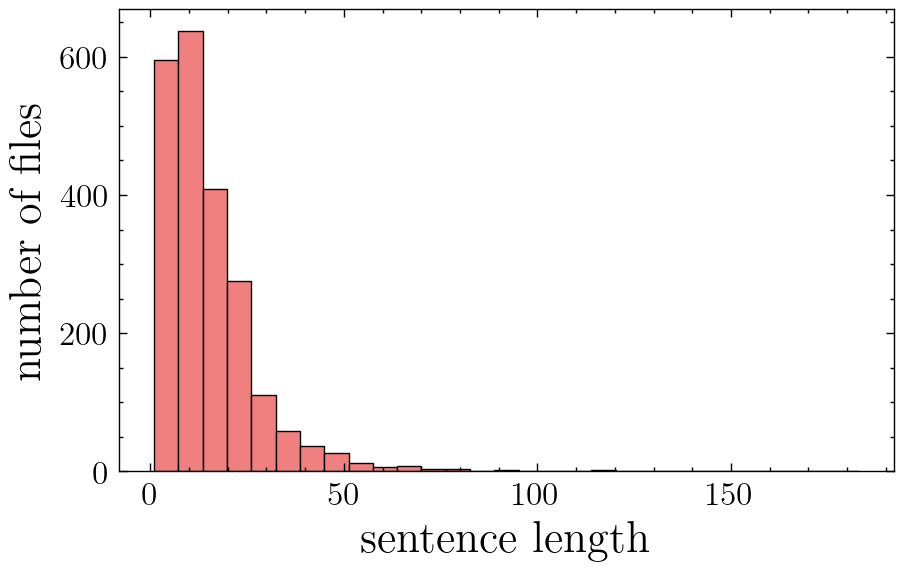

In [21]:
fig, ax = plt.subplots(figsize=(5, 3))

pd.DataFrame.hist(
    data=book_sent_df,
    column='len',
    ax=ax,
    bins=29,
    legend=False,
    color='lightcoral',
    alpha=1,
    edgecolor='k',
    lw=0.5,
)

ax.set_title(book_filename, fontsize=lables_fs)

ax.tick_params(axis='both', which='major', labelsize=ticks_fs)

plt.title(None)
plt.xlabel('sentence length', fontsize=lables_fs)
plt.ylabel('number of files', fontsize=lables_fs)

ax.grid(False)
plt.show()
# fig.savefig(f'figures/name.eps', format='eps')

### Prepare all sentences and targets for further prediction

In [22]:
all_inputs = []
all_targets = []

for ind_row in tqdm(range(book_sent_df.shape[0])):
    sentence_this = book_sent_df.iloc[ind_row]['processed']

    input_this = sentence_this
    for mark in REMAIN_PUNCT:
        input_this = input_this.replace(mark, '')

    target_this = tokenize(sentence_this)

    assert len(target_this.split(' ')) == len(input_this.split(' '))
    
    all_inputs.append(input_this)
    all_targets.append(target_this)

100%|████████████████████████████████████| 2188/2188 [00:00<00:00, 30981.44it/s]


In [23]:
# add new rows to DF
book_sent_df['input'] = all_inputs
book_sent_df['target'] = all_targets

### Saving prepared data

In [24]:
book_sent_df.sample(10)

,raw,processed,len,input,target
148,"Трех братьев сих казаки побили, а ее, Гугниху, взяли в плен и подарили своему атаману».","трех братьев сих казаки побили, а ее, гугниху, взяли в плен и подарили своему атаману.",15,трех братьев сих казаки побили а ее гугниху взяли в плен и подарили своему атаману,S S S S C S C C S S S S S S P
340,Сперва дело шло о побеге в Турцию: мысль издавна общая всем недовольным казакам.,"сперва дело шло о побеге в турцию, мысль издавна общая всем недовольным казакам.",13,сперва дело шло о побеге в турцию мысль издавна общая всем недовольным казакам,S S S S S S C S S S S S P
445,На другой день Пугачев выступил и пошел на Татищеву(11).,на другой день пугачев выступил и пошел на татищеву.,9,на другой день пугачев выступил и пошел на татищеву,S S S S S S S S P
882,"Пугачев отступил и хотел идти противу Станиславского, но, перехватив оренбургскую почту, раздумал и возвратился в Бердскую слободу.","пугачев отступил и хотел идти противу станиславского, но, перехватив оренбургскую почту, раздумал и возвратился в бердскую слободу.",17,пугачев отступил и хотел идти противу станиславского но перехватив оренбургскую почту раздумал и возвратился в бердскую слободу,S S S S S S C C S S C S S S S S P
559,"Оренбург претерпел бедственную осаду, коей любопытное изображение сохранено самим Рейнсдорпом(2).","оренбург претерпел бедственную осаду, коей любопытное изображение сохранено самим рейнсдорпом.",10,оренбург претерпел бедственную осаду коей любопытное изображение сохранено самим рейнсдорпом,S S S C S S S S S P
1858,"Михельсон, шедший к Арзамасу, отрядил Харина к Ядринску, куда спешил и граф Меллин.","михельсон, шедший к арзамасу, отрядил харина к ядринску, куда спешил и граф меллин.",13,михельсон шедший к арзамасу отрядил харина к ядринску куда спешил и граф меллин,C S S C S S S C S S S S P
682,Пугачев скучал их опекою.,пугачев скучал их опекою.,4,пугачев скучал их опекою,S S S P
1133,"Генерал-майору Мансурову вверено было правое крыло для прикрытия Самарской линии, куда со своими отрядами следовал майор Муфель и подполковник Гринев.","генерал-майору мансурову вверено было правое крыло для прикрытия самарской линии, куда со своими отрядами следовал майор муфель и подполковник гринев.",20,генерал-майору мансурову вверено было правое крыло для прикрытия самарской линии куда со своими отрядами следовал майор муфель и подполковник гринев,S S S S S S S S S C S S S S S S S S S P
880,"30 ноября он снова окружил крепость и целый день стрелял по ней из пушек, покушаясь на приступ то с той, то с другой стороны.","30 ноября он снова окружил крепость и целый день стрелял по ней из пушек, покушаясь на приступ то с той, то с другой стороны.",24,30 ноября он снова окружил крепость и целый день стрелял по ней из пушек покушаясь на приступ то с той то с другой стороны,S S S S S S S S S S S S S C S S S S S C S S S P
259,"Сей способ ловли чрезвычайно выгоден для тех, которые занимаются оным; но, не допуская рыбы вверх Урала, он делает подрыв багренным промышленникам.","сей способ ловли чрезвычайно выгоден для тех, которые занимаются оным, но, не допуская рыбы вверх урала, он делает подрыв багренным промышленникам.",21,сей способ ловли чрезвычайно выгоден для тех которые занимаются оным но не допуская рыбы вверх урала он делает подрыв багренным промышленникам,S S S S S S C S S C C S S S S C S S S S P


In [25]:
pushkin_prepared_dir = '../data/prepared/pushkin'
book_filename_csv = book_filename.split('.')[0] + '.csv'

In [26]:
# saving dataframe (only 'input' and 'target' columns)
book_sent_df[['input', 'target']].to_csv(os.path.join(pushkin_prepared_dir, book_filename_csv))